### Scraping data from the website "https://books.toscrape.com/ " 
- categories
- products of each categories (products name)
- prices
- quantity available in stock
- No Ratings
- No Reviews
- image link
### creating a data base to store the scraped data
### collect data from the database "sqlite3" to a csv file 
### load the data from the csv file in to dataframe for analysis
### make visualisations

In [67]:
#importations
import re
import csv
import math
import requests
import pandas as pd
import sqlite3 as sql
#import mysql.connector
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
from words2num import words2num

In [3]:
# Function to get all the categories of books 

def get_categories():
    url = "https://books.toscrape.com/index.html"
    response = requests.get(url)
    list_categories = []
    if response.status_code == 200:
        soup = BeautifulSoup(response.content, "html.parser")
        categories = soup.find("ul", class_ = "nav-list").find_all("a")
        #print((categories))
        for category in categories:
            category_name = category.text.strip()
            category_url = "https://books.toscrape.com/"+ category["href"]
            list_categories.append({"category name": category_name, "category url": category_url})
    return list_categories 
categories_info = get_categories()


In [4]:
# Function to extract all product informations 
def get_product_info(category):
    # list to contain all the products informations
    list_dict_products = []
    n=2
    # sending a request to get specifique category url to extract each product url
    response = requests.get(category["category url"])
    # testing if our request have succeed
    if response.status_code == 200:
        # Getting the html code of the page
        soup = BeautifulSoup(response.text, "html.parser")
        # geting all products links
        products_link = soup.find_all("h3")
        for product_link in products_link:
            # part of url link for the product
            prod_url = "https://books.toscrape.com/catalogue/"
            
            # getting the end part of the product url
            prod_part_url = re.sub(r"\../", "",product_link.a["href"].strip())
            # concatenating the url to get a complet url
            product_url = prod_url + prod_part_url
            
            print("scraping informations using product link:\n", product_url)
            # sending a request to get infos onproducts of a category
            res = requests.get(product_url)
            if res.status_code == 200:
                sp = BeautifulSoup(res.text, "html.parser")
                # getting the list of all the products on the page
                books = sp.find_all("article", class_ = "product_page")
                # iterating to get all the infos on the each product
                for book in books:
                    
                    list_products_desc = [] # list to contain the find all result of the prod_description
                    
                    list_prod_info = [] # list to contain all info about tax price etc..
                    
                    prod_name = book.find("h1").text # getting ptoduct name
                    # product price
                    prod_price = re.sub(r"^.{%d}" % n, "", book.find("p", class_ = "price_color").text) # product price
                    
                    # Extraction of product quantity available
                    product_available = book.find("p", class_ = "availability").text.strip()
                    prod_quantity_available = re.findall(r"\b\d+\b", product_available)[0] # quantity available in stock
                    
                    # Extraction of product Descrition
                    all_prod_description = book.find_all("p")
                    for each_desc in all_prod_description:
                        list_products_desc.append(each_desc.text.strip())
                    prod_description = list_products_desc[3] # product description
                    
                    # Extraction of product info i.e tax, upc, etc 
                    prod_info = book.find_all("td")
                    for each_info in prod_info:
                        list_prod_info.append(each_info.text.strip())
                    product_upc = list_prod_info[0] # product upc
                    product_type = list_prod_info[1] # product type
                    product_price_excl_tax = re.sub(r"^.{%d}" % n, "", list_prod_info[2]) # product price excl
                    product_price_incl_tax = re.sub(r"^.{%d}" % n, "", list_prod_info[3]) # product tax incl
                    tax = re.sub(r"^.{%d}" % n, "", list_prod_info[4]) # product tax
                    
                    # Extraction of product reviews
                    number_review = list_prod_info[6]
                    # Extraction of product Ratings
                    product_ratings = words2num(book.find("p", class_ = "star-rating")["class"][1])
                    
                    # Extraction of product image link
                    part2_image = re.sub(r"\../", "",book.find("div", class_ = "active").find("img")["src"])
                    part1_image = "https://books.toscrape.com/"
                    product_image = part1_image + part2_image
                       
                    # resultant list containing a dictionary or all informations on products.
                    list_dict_products.append(
                        {
                            "category": category["category name"],
                            "category_url": category["category url"],
                            "product_upc": product_upc,
                            "product_name": prod_name, 
                            "product_price": prod_price, 
                            "price_excl_tax": product_price_excl_tax, 
                            "Price_incl_tax": product_price_incl_tax, 
                            "tax": tax, 
                            "product_quantity": prod_quantity_available,
                            "product_description": prod_description, 
                            "number_reviews":number_review,
                            "product_image": product_image,
                            "product_ratings": product_ratings,
                            "product_type": product_type
                        }
                    )
    return list_dict_products
#t = products_part_links("travel_2", "https://books.toscrape.com/catalogue/category/books/travel_2/index.html")

In [5]:
# Scraping th whole website
def scrape_website():
    # generating categories
    categories = get_categories()
    
    partern = r"\b\d+\b" # pattern toget digits in a string 
    
    all_p = []
    # getting all the product in each category
    for category in categories[1:]:
        # converting the name of each category to string so as to match with url
        category_p = category["category name"].lower().replace(" ", "-")
        #url = f"https://books.toscrape.com/catalogue/category/books/{category_p}_{cat_num}/index.html"
        url = category["category url"]
        response = requests.get(url) # sending a request to the page
        
        if response.status_code == 200:
            
            soup = BeautifulSoup(response.content, "html.parser") # getting the html content of the page
            
            matches = soup.find("form", class_ = "form-horizontal").text.strip() # getting number of product in each page
            
            num_prod = re.findall(partern, matches) # using regex to get the total of each page
            # if we have 20 or less product in a page we proceed as follow
            
            num_prod = int(num_prod[0])
            print("There are ", num_prod, " data to scrape in category ", category["category name"])
            # if we have a total product less than 20 
            if num_prod <= 20:
                
                #print("less than 20 pages")
                all_p.extend(get_product_info(category))
                
            else:# else if the total prod is greater than 20 we iterate through the pages
               
            # print("More than 20 pages")
                pages = math.ceil(num_prod / 20) # getting the number of pages to go through
                print(pages)
                category["category url"] = category["category url"].replace("index.html", "page-")
                for page in range(1, pages + 1): # Iterating through all the pages of a category
                    category["category url"] = category["category url"].replace("page-"+f"{page - 1}.html", "page-")+f"{page}.html"

                    all_p.extend(get_product_info(category))
    
    return all_p
    
all_products = scrape_website()

There are  11  data to scrape in category  Travel
scraping informations using product link:
 https://books.toscrape.com/catalogue/its-only-the-himalayas_981/index.html
scraping informations using product link:
 https://books.toscrape.com/catalogue/full-moon-over-noahs-ark-an-odyssey-to-mount-ararat-and-beyond_811/index.html
scraping informations using product link:
 https://books.toscrape.com/catalogue/see-america-a-celebration-of-our-national-parks-treasured-sites_732/index.html
scraping informations using product link:
 https://books.toscrape.com/catalogue/vagabonding-an-uncommon-guide-to-the-art-of-long-term-world-travel_552/index.html
scraping informations using product link:
 https://books.toscrape.com/catalogue/under-the-tuscan-sun_504/index.html
scraping informations using product link:
 https://books.toscrape.com/catalogue/a-summer-in-europe_458/index.html
scraping informations using product link:
 https://books.toscrape.com/catalogue/the-great-railway-bazaar_446/index.html
scr

scraping informations using product link:
 https://books.toscrape.com/catalogue/the-guernsey-literary-and-potato-peel-pie-society_253/index.html
scraping informations using product link:
 https://books.toscrape.com/catalogue/girl-in-the-blue-coat_160/index.html
https://books.toscrape.com/catalogue/category/books/historical-fiction_4/page-2.html
scraping informations using product link:
 https://books.toscrape.com/catalogue/between-shades-of-gray_128/index.html
scraping informations using product link:
 https://books.toscrape.com/catalogue/while-you-were-mine_97/index.html
scraping informations using product link:
 https://books.toscrape.com/catalogue/the-secret-healer_80/index.html
scraping informations using product link:
 https://books.toscrape.com/catalogue/starlark_56/index.html
scraping informations using product link:
 https://books.toscrape.com/catalogue/lost-among-the-living_31/index.html
scraping informations using product link:
 https://books.toscrape.com/catalogue/a-spys-dev

scraping informations using product link:
 https://books.toscrape.com/catalogue/prodigy-the-graphic-novel-legend-the-graphic-novel-2_207/index.html
scraping informations using product link:
 https://books.toscrape.com/catalogue/persepolis-the-story-of-a-childhood-persepolis-1-2_206/index.html
scraping informations using product link:
 https://books.toscrape.com/catalogue/original-fake_203/index.html
scraping informations using product link:
 https://books.toscrape.com/catalogue/grayson-vol-3-nemesis-grayson-3_164/index.html
scraping informations using product link:
 https://books.toscrape.com/catalogue/fruits-basket-vol-3-fruits-basket-3_159/index.html
scraping informations using product link:
 https://books.toscrape.com/catalogue/black-butler-vol-1-black-butler-1_130/index.html
scraping informations using product link:
 https://books.toscrape.com/catalogue/awkward_124/index.html
scraping informations using product link:
 https://books.toscrape.com/catalogue/the-sandman-vol-2-the-dolls

scraping informations using product link:
 https://books.toscrape.com/catalogue/suddenly-in-love-lake-haven-1_835/index.html
scraping informations using product link:
 https://books.toscrape.com/catalogue/something-more-than-this_834/index.html
scraping informations using product link:
 https://books.toscrape.com/catalogue/doing-it-over-most-likely-to-1_802/index.html
scraping informations using product link:
 https://books.toscrape.com/catalogue/the-wedding-pact-the-omalleys-2_767/index.html
scraping informations using product link:
 https://books.toscrape.com/catalogue/hold-your-breath-search-and-rescue-1_700/index.html
scraping informations using product link:
 https://books.toscrape.com/catalogue/dirty-dive-bar-1_615/index.html
scraping informations using product link:
 https://books.toscrape.com/catalogue/take-me-home-tonight-rock-star-romance-3_605/index.html
scraping informations using product link:
 https://books.toscrape.com/catalogue/off-the-hook-fishing-for-trouble-1_601/ind

scraping informations using product link:
 https://books.toscrape.com/catalogue/eligible-the-austen-project-4_692/index.html
https://books.toscrape.com/catalogue/category/books/fiction_10/page-2.html
scraping informations using product link:
 https://books.toscrape.com/catalogue/eight-hundred-grapes_690/index.html
scraping informations using product link:
 https://books.toscrape.com/catalogue/dear-mr-knightley_684/index.html
scraping informations using product link:
 https://books.toscrape.com/catalogue/cometh-the-hour-the-clifton-chronicles-6_681/index.html
scraping informations using product link:
 https://books.toscrape.com/catalogue/balloon-animals_665/index.html
scraping informations using product link:
 https://books.toscrape.com/catalogue/a-man-called-ove_653/index.html
scraping informations using product link:
 https://books.toscrape.com/catalogue/the-silent-sister-riley-macpherson-1_641/index.html
scraping informations using product link:
 https://books.toscrape.com/catalogue/

scraping informations using product link:
 https://books.toscrape.com/catalogue/red-the-true-story-of-red-riding-hood_210/index.html
scraping informations using product link:
 https://books.toscrape.com/catalogue/horrible-bear_168/index.html
scraping informations using product link:
 https://books.toscrape.com/catalogue/green-eggs-and-ham-beginner-books-b-16_165/index.html
scraping informations using product link:
 https://books.toscrape.com/catalogue/counting-thyme_142/index.html
scraping informations using product link:
 https://books.toscrape.com/catalogue/are-we-there-yet_122/index.html
scraping informations using product link:
 https://books.toscrape.com/catalogue/diary-of-a-minecraft-zombie-book-1-a-scare-of-a-dare-an-unofficial-minecraft-book_99/index.html
scraping informations using product link:
 https://books.toscrape.com/catalogue/matilda_32/index.html
scraping informations using product link:
 https://books.toscrape.com/catalogue/charlie-and-the-chocolate-factory-charlie-bu

scraping informations using product link:
 https://books.toscrape.com/catalogue/13-hours-the-inside-account-of-what-really-happened-in-benghazi_645/index.html
https://books.toscrape.com/catalogue/category/books/nonfiction_13/page-3.html
scraping informations using product link:
 https://books.toscrape.com/catalogue/the-lonely-city-adventures-in-the-art-of-being-alone_639/index.html
scraping informations using product link:
 https://books.toscrape.com/catalogue/the-diary-of-a-young-girl_634/index.html
scraping informations using product link:
 https://books.toscrape.com/catalogue/snatched-how-a-drug-queen-went-undercover-for-the-dea-and-was-kidnapped-by-colombian-guerillas_631/index.html
scraping informations using product link:
 https://books.toscrape.com/catalogue/furiously-happy-a-funny-book-about-horrible-things_619/index.html
scraping informations using product link:
 https://books.toscrape.com/catalogue/the-sleep-revolution-transforming-your-life-one-night-at-a-time_608/index.html

scraping informations using product link:
 https://books.toscrape.com/catalogue/into-the-wild_177/index.html
scraping informations using product link:
 https://books.toscrape.com/catalogue/in-the-garden-of-beasts-love-terror-and-an-american-family-in-hitlers-berlin_175/index.html
scraping informations using product link:
 https://books.toscrape.com/catalogue/i-am-malala-the-girl-who-stood-up-for-education-and-was-shot-by-the-taliban_172/index.html
scraping informations using product link:
 https://books.toscrape.com/catalogue/gratitude_163/index.html
scraping informations using product link:
 https://books.toscrape.com/catalogue/disrupted-my-misadventure-in-the-start-up-bubble_148/index.html
scraping informations using product link:
 https://books.toscrape.com/catalogue/brave-enough_135/index.html
scraping informations using product link:
 https://books.toscrape.com/catalogue/born-to-run-a-hidden-tribe-superathletes-and-the-greatest-race-the-world-has-never-seen_133/index.html
scraping

scraping informations using product link:
 https://books.toscrape.com/catalogue/grumbles_812/index.html
scraping informations using product link:
 https://books.toscrape.com/catalogue/first-steps-for-new-christians-print-edition_808/index.html
scraping informations using product link:
 https://books.toscrape.com/catalogue/eureka-trivia-60_805/index.html
scraping informations using product link:
 https://books.toscrape.com/catalogue/drive-the-surprising-truth-about-what-motivates-us_804/index.html
scraping informations using product link:
 https://books.toscrape.com/catalogue/done-rubbed-out-reightman-bailey-1_803/index.html
scraping informations using product link:
 https://books.toscrape.com/catalogue/beauty-restored-riley-family-legacy-novellas-3_794/index.html
scraping informations using product link:
 https://books.toscrape.com/catalogue/ayumis-violin_791/index.html
scraping informations using product link:
 https://books.toscrape.com/catalogue/anonymous_790/index.html
scraping inf

scraping informations using product link:
 https://books.toscrape.com/catalogue/the-hobbit-middle-earth-universe_447/index.html
scraping informations using product link:
 https://books.toscrape.com/catalogue/the-fellowship-of-the-ring-the-lord-of-the-rings-1_442/index.html
scraping informations using product link:
 https://books.toscrape.com/catalogue/ship-leaves-harbor-essays-on-travel-by-a-recovering-journeyman_438/index.html
scraping informations using product link:
 https://books.toscrape.com/catalogue/musicophilia-tales-of-music-and-the-brain_436/index.html
scraping informations using product link:
 https://books.toscrape.com/catalogue/what-if-serious-scientific-answers-to-absurd-hypothetical-questions_416/index.html
scraping informations using product link:
 https://books.toscrape.com/catalogue/the-fault-in-our-stars_403/index.html
scraping informations using product link:
 https://books.toscrape.com/catalogue/the-dream-thieves-the-raven-cycle-2_400/index.html
scraping informatio

scraping informations using product link:
 https://books.toscrape.com/catalogue/jane-eyre_27/index.html
scraping informations using product link:
 https://books.toscrape.com/catalogue/frankenstein_20/index.html
There are  16  data to scrape in category  Science Fiction
scraping informations using product link:
 https://books.toscrape.com/catalogue/mesaerion-the-best-science-fiction-stories-1800-1849_983/index.html
scraping informations using product link:
 https://books.toscrape.com/catalogue/join_902/index.html
scraping informations using product link:
 https://books.toscrape.com/catalogue/william-shakespeares-star-wars-verily-a-new-hope-william-shakespeares-star-wars-4_871/index.html
scraping informations using product link:
 https://books.toscrape.com/catalogue/the-project_856/index.html
scraping informations using product link:
 https://books.toscrape.com/catalogue/soft-apocalypse_833/index.html
scraping informations using product link:
 https://books.toscrape.com/catalogue/sleepin

scraping informations using product link:
 https://books.toscrape.com/catalogue/the-raven-king-the-raven-cycle-4_412/index.html
scraping informations using product link:
 https://books.toscrape.com/catalogue/find-her-detective-dd-warren-8_373/index.html
https://books.toscrape.com/catalogue/category/books/add-a-comment_18/page-3.html
scraping informations using product link:
 https://books.toscrape.com/catalogue/evicted-poverty-and-profit-in-the-american-city_372/index.html
scraping informations using product link:
 https://books.toscrape.com/catalogue/a-game-of-thrones-a-song-of-ice-and-fire-1_358/index.html
scraping informations using product link:
 https://books.toscrape.com/catalogue/a-clash-of-kings-a-song-of-ice-and-fire-2_356/index.html
scraping informations using product link:
 https://books.toscrape.com/catalogue/the-tipping-point-how-little-things-can-make-a-big-difference_284/index.html
scraping informations using product link:
 https://books.toscrape.com/catalogue/the-rest-i

scraping informations using product link:
 https://books.toscrape.com/catalogue/harry-potter-and-the-chamber-of-secrets-harry-potter-2_325/index.html
scraping informations using product link:
 https://books.toscrape.com/catalogue/the-rose-the-dagger-the-wrath-and-the-dawn-2_278/index.html
scraping informations using product link:
 https://books.toscrape.com/catalogue/soldier-talon-3_222/index.html
scraping informations using product link:
 https://books.toscrape.com/catalogue/midnight-riot-peter-grant-rivers-of-london-books-1_194/index.html
scraping informations using product link:
 https://books.toscrape.com/catalogue/heir-to-the-sky_166/index.html
scraping informations using product link:
 https://books.toscrape.com/catalogue/eragon-the-inheritance-cycle-1_153/index.html
scraping informations using product link:
 https://books.toscrape.com/catalogue/darkfever-fever-1_145/index.html
scraping informations using product link:
 https://books.toscrape.com/catalogue/ash_123/index.html
scra

scraping informations using product link:
 https://books.toscrape.com/catalogue/two-boys-kissing_294/index.html
scraping informations using product link:
 https://books.toscrape.com/catalogue/the-new-guy-and-other-senior-year-distractions_266/index.html
scraping informations using product link:
 https://books.toscrape.com/catalogue/the-land-of-10000-madonnas_258/index.html
scraping informations using product link:
 https://books.toscrape.com/catalogue/scarlet-the-lunar-chronicles-2_218/index.html
scraping informations using product link:
 https://books.toscrape.com/catalogue/legend-legend-1_184/index.html
scraping informations using product link:
 https://books.toscrape.com/catalogue/lady-renegades-rebel-belle-3_181/index.html
scraping informations using product link:
 https://books.toscrape.com/catalogue/golden-heart-of-dread-3_161/index.html
scraping informations using product link:
 https://books.toscrape.com/catalogue/cinder-the-lunar-chronicles-1_139/index.html
scraping informatio

scraping informations using product link:
 https://books.toscrape.com/catalogue/civilization-and-its-discontents_140/index.html
scraping informations using product link:
 https://books.toscrape.com/catalogue/8-keys-to-mental-health-through-exercise_114/index.html
There are  9  data to scrape in category  Autobiography
scraping informations using product link:
 https://books.toscrape.com/catalogue/the-argonauts_837/index.html
scraping informations using product link:
 https://books.toscrape.com/catalogue/m-train_598/index.html
scraping informations using product link:
 https://books.toscrape.com/catalogue/lab-girl_595/index.html
scraping informations using product link:
 https://books.toscrape.com/catalogue/approval-junkie-adventures-in-caring-too-much_363/index.html
scraping informations using product link:
 https://books.toscrape.com/catalogue/running-with-scissors_215/index.html
scraping informations using product link:
 https://books.toscrape.com/catalogue/me-talk-pretty-one-day_193

scraping informations using product link:
 https://books.toscrape.com/catalogue/foolproof-preserving-a-guide-to-small-batch-jams-jellies-pickles-condiments-and-more-a-foolproof-guide-to-making-small-batch-jams-jellies-pickles-condiments-and-more_978/index.html
scraping informations using product link:
 https://books.toscrape.com/catalogue/the-pioneer-woman-cooks-dinnertime-comfort-classics-freezer-food-16-minute-meals-and-other-delicious-ways-to-solve-supper_943/index.html
scraping informations using product link:
 https://books.toscrape.com/catalogue/my-paris-kitchen-recipes-and-stories_910/index.html
scraping informations using product link:
 https://books.toscrape.com/catalogue/mama-tried-traditional-italian-cooking-for-the-screwed-crude-vegan-and-tattooed_908/index.html
scraping informations using product link:
 https://books.toscrape.com/catalogue/layered-baking-building-and-styling-spectacular-cakes_904/index.html
scraping informations using product link:
 https://books.toscrape.

scraping informations using product link:
 https://books.toscrape.com/catalogue/benjamin-franklin-an-american-life_460/index.html
scraping informations using product link:
 https://books.toscrape.com/catalogue/the-rise-of-theodore-roosevelt-theodore-roosevelt-1_276/index.html
There are  11  data to scrape in category  Thriller
scraping informations using product link:
 https://books.toscrape.com/catalogue/in-her-wake_980/index.html
scraping informations using product link:
 https://books.toscrape.com/catalogue/the-elephant-tree_968/index.html
scraping informations using product link:
 https://books.toscrape.com/catalogue/behind-closed-doors_962/index.html
scraping informations using product link:
 https://books.toscrape.com/catalogue/you-you-1_784/index.html
scraping informations using product link:
 https://books.toscrape.com/catalogue/the-guilty-will-robie-4_750/index.html
scraping informations using product link:
 https://books.toscrape.com/catalogue/the-14th-colony-cotton-malone-11

In [6]:
len(all_products)

1000

### Connection to a data base to insert our data.

In [10]:
db_name = "books_database.db"
# method to extablish a connection with our db.
def sql_connection(db_name):
    connection = sql.connect(db_name)
    cursor = connection.cursor()
    return cursor, connection


In [68]:
# Droping tables
def drop_tables(db_name):
    cursor, conn = sql_connection(db_name)
    cursor.execute(""" DROP TABLE categories""")
    cursor.execute(""" DROP TABLE products""")
    cursor.execute(""" DROP TABLE stock""")
    print("all table droped")
    conn.commit()
    conn.close()
#drop_tables(db_name)

###  CREATING the tables of our database

In [18]:
# creating the different tables of our database
def create_database_tables(db_name):
    cursor, conn = sql_connection(db_name)
    #IF NOT EXISTs

    #Creating a table category
    cursor.execute('''CREATE TABLE IF NOT EXISTS 
                            categories (
                                id_category INTEGER PRIMARY KEY AUTOINCREMENT, 
                                category_name TEXT, 
                                category_link TEXT 
                    )''')
    
    # Creating a table product
    cursor.execute(''' CREATE TABLE IF NOT EXISTS 
                            products (
                                id_product INTEGER PRIMARY KEY AUTOINCREMENT,
                                id_category INTEGER,
                                product_name TEXT, 
                                product_type TEXT, 
                                product_upc TEXT, 
                                price_excl REAL, 
                                price_incl REAL, 
                                tax REAL, 
                                image_link TEXT,
                                review INTEGER, 
                                rating INTEGER,
                                FOREIGN KEY (id_category) REFERENCES categories(id_category)
                )''')
    
    # Creating a table Stock
    cursor.execute(''' CREATE TABLE IF NOT EXISTS 
                            stock (
                                id_stock INTEGER PRIMARY KEY AUTOINCREMENT,
                                id_product INTEGER,
                                avl_quantity INTEGER,
                                FOREIGN KEY (id_product) REFERENCES product(id_product)

                        ) ''')
    print("Tables created succesfuly")
    conn.commit()
    conn.close()
create_database_tables(db_name)

Tables created succesfuly


In [111]:
cursor, conn = sql_connection(db_name)

### Insertion in table categories

In [20]:
for category in categories_info[1:]:
    category_data = (category["category name"], category["category url"]) 
    cursor.execute("INSERT INTO categories (category_name, category_link) VALUES (?,?)", category_data)
    #category_id = cursor.lastrowid

### Insertion of all the products

In [21]:
for product in all_products:
    # Getting id categories 
    category_id = cursor.execute(""" SELECT id_category FROM categories WHERE category_name == ? """, (product["category"],)).fetchall()[0][0]
    
    products_data = (category_id, product["product_name"], product["product_type"], product["product_upc"], product["price_excl_tax"], product["Price_incl_tax"], product["tax"], product["product_image"], product["number_reviews"], product["product_ratings"])
    
    cursor.execute("INSERT INTO products (id_category,product_name,product_type,product_upc,price_excl,price_incl,tax,image_link,review,rating) VALUES (?,?,?,?,?,?,?,?,?,?)", products_data)
   # product_id = cursor.lastrowid

### INSERTION on table stock

In [291]:
for quantity in all_products:
    print(quantity)
    break
    product_id = cursor.execute(""" SELECT id_product FROM products WHERE product_name == ? """, (quantity["product_name"],)).fetchall()[0]
    stock_data = (product_id, quantity["product_quantity"])
    cursor.execute("INSERT INTO stock (id_product, avl_quantity) VALUES (?,?)", stock_data)
    #stock_id = cursor.lastrowid

{'category': 'Travel', 'category_url': 'https://books.toscrape.com/catalogue/category/books/travel_2/index.html', 'product_upc': 'a22124811bfa8350', 'product_name': "It's Only the Himalayas", 'product_price': '45.17', 'price_excl_tax': '45.17', 'Price_incl_tax': '45.17', 'tax': '0.00', 'product_quantity': '19', 'product_description': 'â\x80\x9cWherever you go, whatever you do, just . . . donâ\x80\x99t do anything stupid.â\x80\x9d â\x80\x94My MotherDuring her yearlong adventure backpacking from South Africa to Singapore, S. Bedford definitely did a few things her mother might classify as "stupid." She swam with great white sharks in South Africa, ran from lions in Zimbabwe, climbed a Himalayan mountain without training in Nepal, and wa â\x80\x9cWherever you go, whatever you do, just . . . donâ\x80\x99t do anything stupid.â\x80\x9d â\x80\x94My MotherDuring her yearlong adventure backpacking from South Africa to Singapore, S. Bedford definitely did a few things her mother might classify a

### SELECT of TABLE product

In [121]:
cursor.execute(""" SELECT (p.rating), id_product FROM products p
                       WHERE p.product_name = "The Star-Touched Queen"
                       """)
print(cursor.fetchall())

[(5, 701), (5, 708)]


### SELECT from the table categories

In [295]:
cursor.execute("""
                SELECT id_category FROM categories
                    WHERE category_name == "Crime"
                """).fetchall()[0][0]
#ids = cursor.fetchall()
#(ids[0][0])

50

### SELECT on table stock 

In [31]:
cursor.execute("""
    SELECT p.price_excl, s.avl_quantity 
    FROM products p 
    JOIN stock s ON p.id_product = s.id_product 
    WHERE p.product_name = 'Tipping the Velvet'
""")
print(cursor.fetchall()[0])


(53.74, 20)


### collecting the data to analyse fro our db to a csv file. (from sql to csv)

In [107]:
cursor.execute(""" SELECT c.category_name, p.product_name, p.price_incl, s.avl_quantity, p.rating 
                   FROM products p
                   JOIN categories c ON p.id_category = c.id_category
                   JOIN stock s ON p.id_product = s.id_product""")

In [108]:
cursor.description

(('category_name', None, None, None, None, None, None),
 ('product_name', None, None, None, None, None, None),
 ('price_incl', None, None, None, None, None, None),
 ('avl_quantity', None, None, None, None, None, None),
 ('rating', None, None, None, None, None, None))

In [109]:
header = ["Categoy name", "Product name", "Product price", "Available quantity", "Ratings"]

In [110]:
with open ("liste_books.csv", "w") as csv_file:
    writer = csv.writer(csv_file)
    writer.writerow(header)
    for each_row in cursor:
        writer.writerow(each_row)
conn.commit()
conn.close()

### Loading our data from the csv file to a dataframe 

In [262]:
#loqd data from csv
def load_data():
    return pd.read_csv("liste_books.csv")
df = load_data()

### DATA EXPLORATION

In [269]:
def summarised_data(df):
    # printing the dimension of df
    print("dataframe demension \n")
    print(df.shape, "\n")
    
    # displaying information about each data column
    print("dataframe info \n")
    print(df.info(), "\n")
    
    # looking there are somme missing values inour dataframe
    print("Missing values \n")
    print( df.isna().sum(), "\n")
    
    # displaying the statistical summary of our dataframe
    print("Statistical summary of our dataframe \n")
    print(df.describe(), "\n")

summarised_data(df)   

dataframe demension 

(1000, 5) 

dataframe info 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Categoy name        1000 non-null   object 
 1   Product name        1000 non-null   object 
 2   Product price       1000 non-null   float64
 3   Available quantity  1000 non-null   int64  
 4   Ratings             1000 non-null   int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 39.2+ KB
None 

Missing values 

Categoy name          0
Product name          0
Product price         0
Available quantity    0
Ratings               0
dtype: int64 

Statistical summary of our dataframe 

       Product price  Available quantity      Ratings
count     1000.00000         1000.000000  1000.000000
mean        35.08407            8.585000     2.923000
std         14.45057            5.654622     1.434967
min         10.00000    

In [260]:
#displaying the first 5lignes of our dataframe
#print("first five rows \n")
df.head()

,Categoy name,Product name,Product price,Available quantity,Ratings
0,Travel,It's Only the Himalayas,45.17,19,2
1,Travel,Full Moon over Noahâs Ark: An Odyssey to Mou...,49.43,15,4
2,Travel,See America: A Celebration of Our National Par...,48.87,14,3
3,Travel,Vagabonding: An Uncommon Guide to the Art of L...,36.94,8,2
4,Travel,Under the Tuscan Sun,37.33,7,3


### Visualizations

### correlation matices

In [272]:
df[["Product price","Available quantity","Ratings"]].corr()

,Product price,Available quantity,Ratings
Product price,1.000000,-0.010337,0.029534
Available quantity,-0.010337,1.000000,0.016166
Ratings,0.029534,0.016166,1.000000


### sorting the df in descending Price and Ratings 

In [180]:
sorted_df_price = df.sort_values(by="Product price", ascending=False)
sorted_df_ratings = df.sort_values(by="Ratings", ascending=False)

### The 10 most expensive products and least expensive products

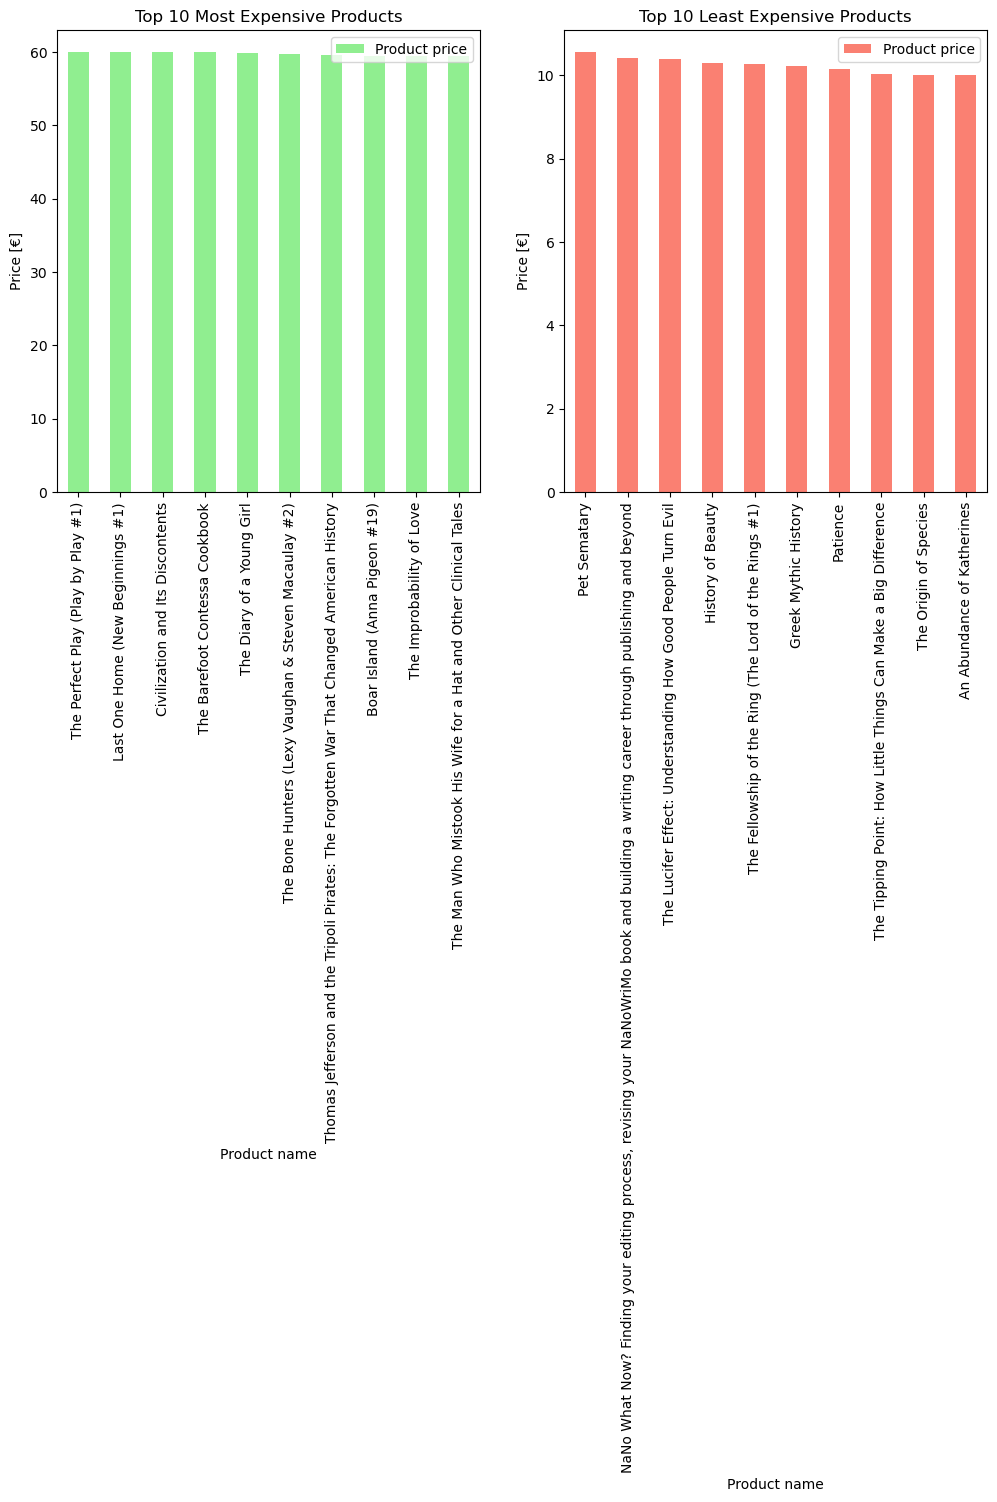

In [207]:
# Select the top 10 rows (MOST expensive and least expensive) products
top_expensive = sorted_df_price.head(10)
bottom_expensive = sorted_df_price.tail(10)

# Plot the selected products
fig, axes = plt.subplots(1,2, figsize=(12, 6))
# plot most expensive products
top_expensive.plot(kind="bar", x="Product name", y="Product price", ax=axes[0], color="lightgreen")
axes[0].set_title("Top 10 Most Expensive Products")
axes[0].set_ylabel("Price [€]")
# plot least expensive products
bottom_expensive.plot(kind="bar", x="Product name", y="Product price", ax=axes[1],color="salmon")
axes[1].set_title("Top 10 Least Expensive Products")
axes[1].set_ylabel("Price [€]")

plt.show()

### The 10 most recomended products and least recommended products

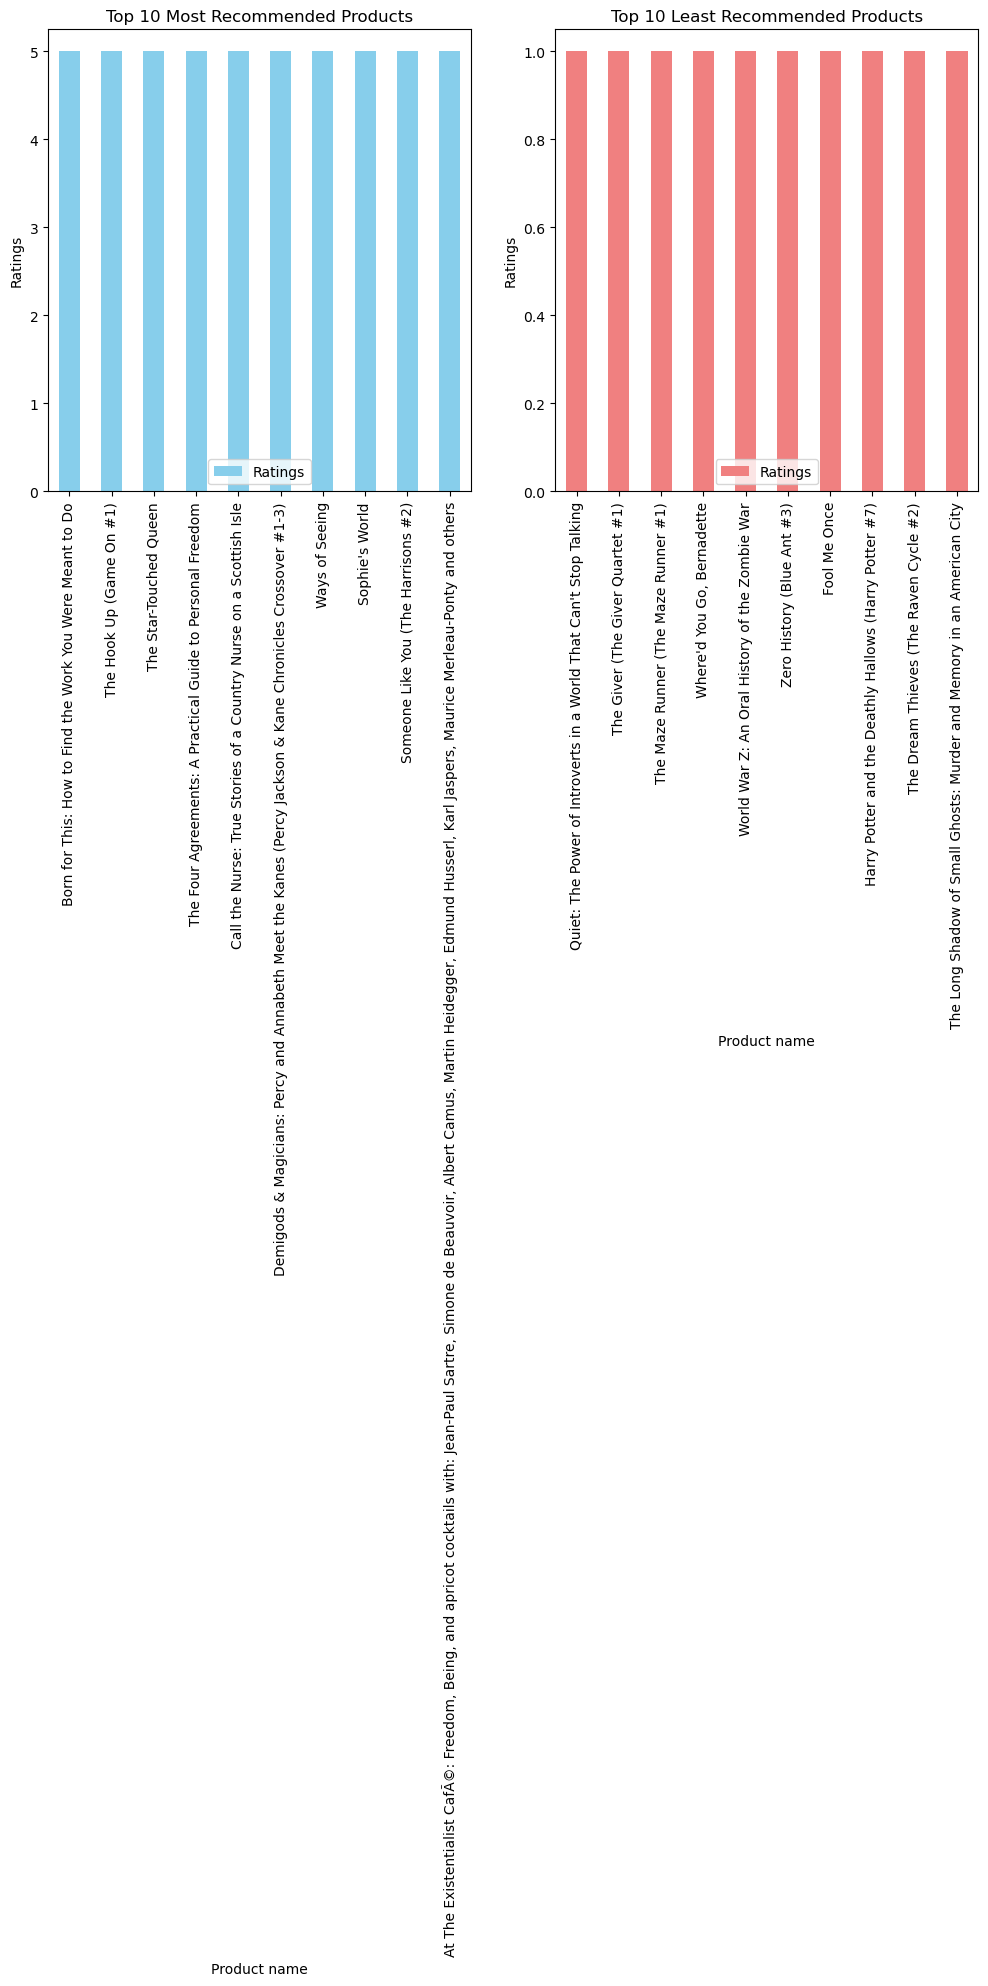

In [284]:
# Select the top 10 rows (MOST recommended and least recommended) products
top_recommended = sorted_df_ratings.head(10)
bottom_recommended = sorted_df_ratings.tail(10)

# Plot the selected products
fig, axes = plt.subplots(1,2, figsize=(12, 6))
# plot most recommended products
top_recommended.plot(kind="bar", x="Product name", y="Ratings", ax=axes[0], color="skyblue")
axes[0].set_title("Top 10 Most Recommended Products")
axes[0].set_ylabel("Ratings")
# plot least recommended products
bottom_recommended.plot(kind="bar", x="Product name", y="Ratings", ax=axes[1],color="lightcoral")
axes[1].set_title("Top 10 Least Recommended Products")
axes[1].set_ylabel("Ratings")

plt.show()

###  Categories with more products in stock

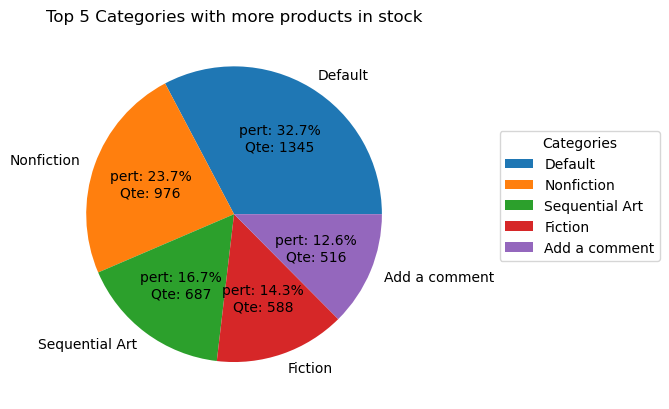

In [258]:
# the Five categories with more products in stock 
top_quantity = df.groupby("Categoy name")["Available quantity"].sum()
# plot 
top_quantity = top_quantity.nlargest(5)

top_quantity.plot(kind = "pie", y = "Available quantity", autopct= lambda pct: f"pert: {pct:.1f}%\nQte: {math.ceil(pct/100 * sum(top_quantity.values))}") #'%1.0f%%')
plt.ylabel("")
plt.title("Top 5 Categories with more products in stock")
plt.legend(title="Categories",
          loc="center left",
          bbox_to_anchor=(1.2, 0, 0.5, 1.1))
plt.show()

### Categories with most expensive products

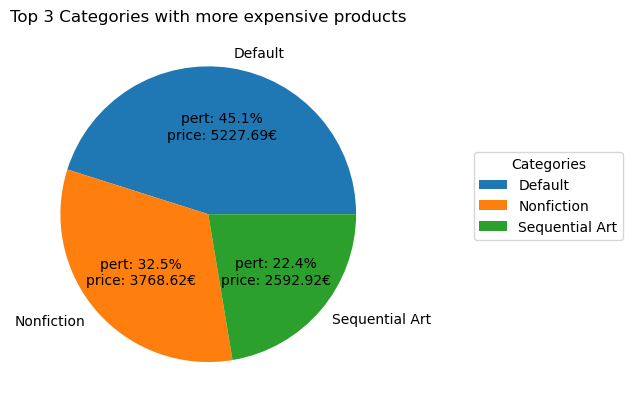

In [259]:
# Three categories with most expensive products
expensive_cat = df.groupby("Categoy name")["Product price"].sum()

expensive_cat = expensive_cat.nlargest(3)

expensive_cat.plot(kind = "pie", y = "Product price", autopct= lambda pct: f"pert: {pct:.1f}%\nprice: {round((pct/100 * sum(expensive_cat.values)), 2)}€")#'%1.0f%%')
plt.ylabel("")
plt.title("Top 3 Categories with more expensive products")
plt.legend(title="Categories",
          loc="center left",
          bbox_to_anchor=(1.2, 0, 0.5, 1.1))
plt.show()
